# ***人脸识别***

# 0. 要解决的问题

① 人脸识别系统通常被分为两大类：

 - 人脸验证：“这是不是本人呢？”，比如说，在某些机场你能够让系统扫描您的面部并验证您是否为本人从而使得您免人工检票通过海关，又或者某些手机能够使用人脸解锁功能。这些都是1：1匹配问题。

 - 人脸识别：“这个人是谁？”，比如说，在视频中的百度员工进入办公室时的脸部识别视频的介绍，无需使用另外的ID卡。这个是1：K的匹配问题。

② FaceNet可以将人脸图像编码为一个128位数字的向量从而进行学习，通过比较两个这样的向量，那么我们就可以确定这两张图片是否是属于同一个人。

③ 在本节中，你将学到：

 - 实现三元组损失函数。

 - 使用一个已经训练好了的模型来将人脸图像映射到一个128位数字的的向量。

 - 使用这些编码来执行人脸验证和人脸识别。

④ 在本练习中，我们将使用预训练的模型，该模型使用"channels first"来表示ConvNet激活，而不是像先前的编程作业一样使用"channels last"。换句话说，一批图像将具有$(m, n_C, n_H, n_W)$的维度，而非$(m, n_H, n_W, n_C)$。这两种方式在开源实现中都有相当大的吸引力。深度学习中也没有统一的标准。

# 1. 导入库

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K

K.set_image_data_format('channels_first')

import time
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import fr_utils
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.
D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# 2. 人脸验证

① 在人脸验证中，你将获得两张图像，并且必须确定它们是否属于同一个人。最简单的方法是逐像素比较两个图像。如果原始图像之间的距离小于选定的阈值，则可能是同一个人！

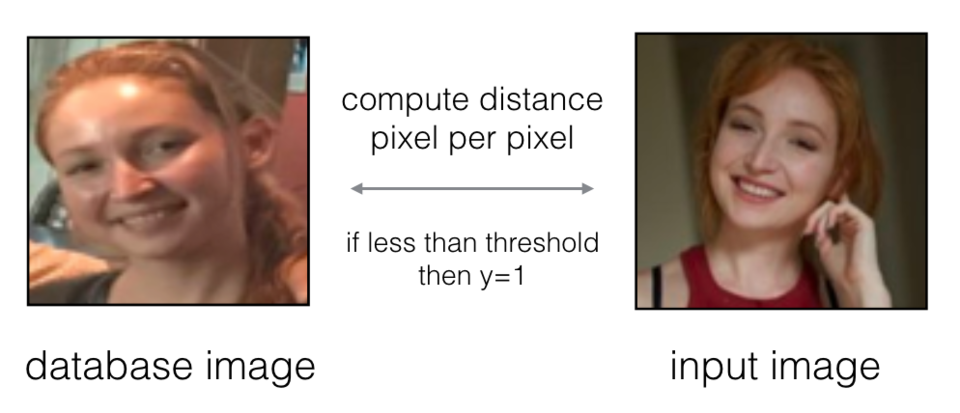

② 当然，此算法的性能确实很差，因为像素值会由于光照，人脸方向，甚至头部位置的微小变化等因素而急剧变化。

③ 你会发现，可以编码$f(img)$而不是使用原始图像，这样对该编码进行逐元素比较就可以更准确地判断两张图片是否属于同一个人。

# 3. 将人脸图像编码为128维向量

## 3.1 使用FaceNet计算编码

① 网络结构遵循Szegedy et al.中的Inception模型。我们提供了初始网络实现。你可以查看文件inception_blocks.py以了解其实现方式。

② 你需要知道的关键事项是：

 - 该网络使用96x96尺寸的RGB图像作为输入。具体来说，输入一张人脸图像（或一批人脸图像）作为维度为$(m, n_C, n_H, n_W) = (m, 3, 96, 96)$的张量。
 - 输出维度为$(m, 128)$的矩阵，该矩阵将每个输入的面部图像编码为128维向量。

① 运行下面的单元格以创建人脸图像模型。

In [2]:
#获取模型
FRmodel = faceRecoModel(input_shape=(3,96,96))

#打印模型的总参数数量
print("参数数量：" + str(FRmodel.count_params()))

参数数量：3743280


② 通过使用128个神经元组成的全连接层作为最后一层，该模型可确保输出是大小为128的编码向量。然后，使用该编码比较两个人脸图像，如下所示：

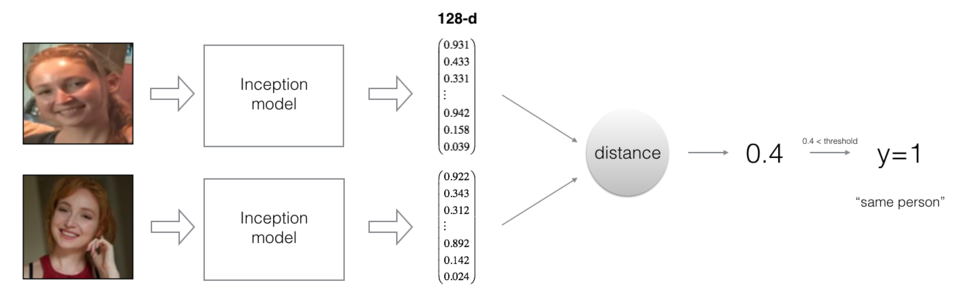

③ 通过计算两种编码和阈值之间的距离，以确定两张图片是否代表同一个人。

## 3.2 三元组损失

① 如果满足以下条件，编码将是一种不错的选择：

 - 同一个人的两张图像的编码彼此非常相似。

 - 不同人的两幅图像的编码差距明显。
 
② 三元组损失函数将上面的形式实现，它会试图将同一个人的两个图像（对于给定的图和正例）的编码“拉近”，同时将两个不同的人的图像（对于给定的图和负例）进一步“分离”。

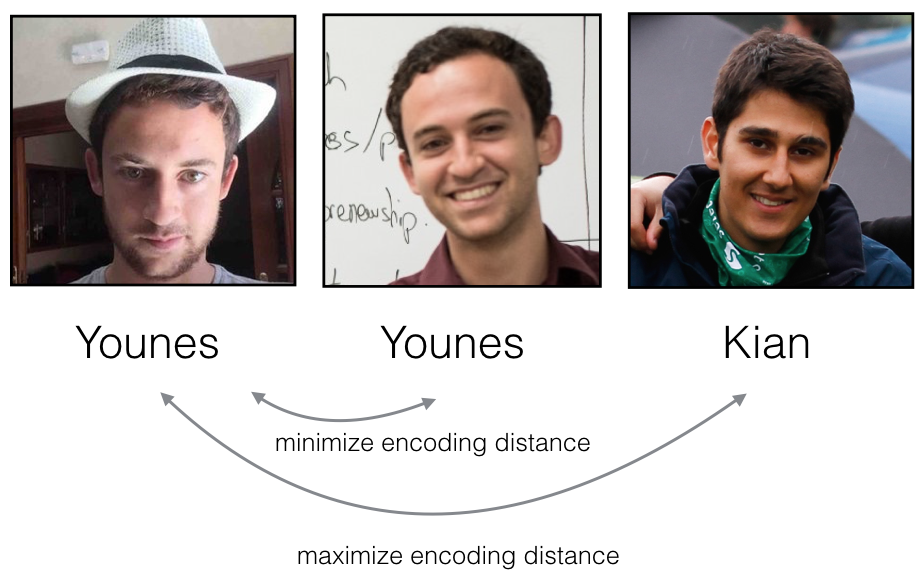

③ 在下一部分中，我们将从左到右调用图片：锚点（A），正向（P），负向（N）。

① 对于图像$x$，其编码表示为$f(x)$，其中$f$是神经网络的计算函数。

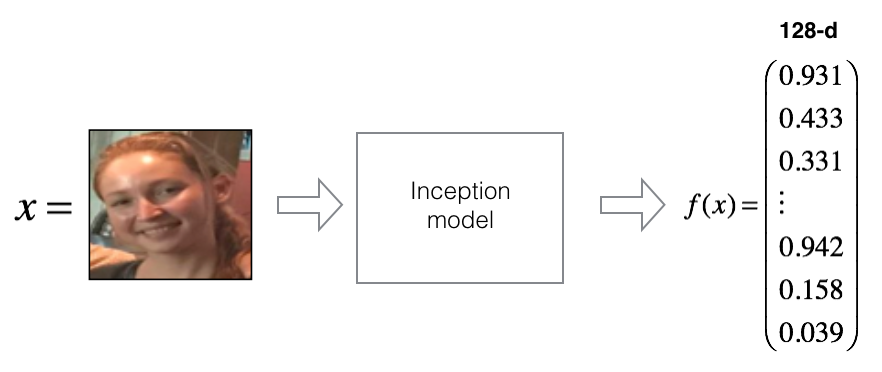

② 我们在模型的末尾添加一个标准化步骤，以使$\mid \mid f(x) \mid \mid_2 = 1$（意味着编码向量应为范数1）。

③ 训练将使用三组图像$(A, P, N)$：

 - A是“锚示例”图像：人的照片。

 - P是“正示例”图像：与锚示例图像相同的人的照片。

 - N是“负示例”图像：与锚示例图像不同的人的照片。
 
④ 这些图像是从我们的训练集中选取的。我们使用$(A^{(i)}, P^{(i)}, N^{(i)})$来表示第$i$个训练示例。

① 如果你想确定一个人的图像$A^{(i)}$比负例图像$N^{(i)}$更接近正例图像$P^{(i)}$ 至少要保证$\alpha$：

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 \tag{1}$$

② 因此，你需要最小化以下"triplet cost"：

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{2}$$

③ 在这里，我们使用符号"$[z]_+$"表示$max(z,0)$。

④ 注意：

 - 项（1）是给定三元组的锚示例“A”与正示例“P”之间的平方距离；期望最小化的值。

 - 项（2）是给定三元组的锚示例“A”和负示例“N”之间的平方距离，期望该值相对较大，因此在它前面有一个负号是有意义的。

 - $\alpha$称为边距。它是一个超参数可以手动调节。我们将使用$\alpha = 0.2$。
 
⑤ 大多数实现方法还需对编码向量进行标准化以使其范数等于1（即$\mid \mid f(img)\mid \mid_2=1$），这里你没必要操心这个。现在我们要实现公式(2)，由以下4步构成：

 - 计算“锚示例”和“正示例”编码之间的距离：$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
 - 计算“锚示例”和“负示例”编码之间的距离：$\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
 - 根据每个训练示例计算公式：$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
 - 通过将最大值取为零并对训练示例求和来计算完整公式：$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+$
 
⑥ 一些有用的函数：tf.reduce_sum(), tf.square(), tf.subtract(), tf.add(), tf.maximum()。对于步骤1和步骤2，你需要加上$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$and$\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$，而在第4步中，你需要将训练示例求总。

In [3]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    根据公式（4）实现三元组损失函数
    
    参数：
        y_true -- true标签，当你在Keras里定义了一个损失函数的时候需要它，但是这里不需要。
        y_pred -- 列表类型，包含了如下参数：
            anchor -- 给定的“anchor”图像的编码，维度为(None,128)
            positive -- “positive”图像的编码，维度为(None,128)
            negative -- “negative”图像的编码，维度为(None,128)
        alpha -- 超参数，阈值
    
    返回：
        loss -- 实数，损失的值
    """
    #获取anchor, positive, negative的图像编码
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    #第一步：计算"anchor" 与 "positive"之间编码的距离，这里需要使用axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    
    #第二步：计算"anchor" 与 "negative"之间编码的距离，这里需要使用axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    #第三步：减去之前的两个距离，然后加上alpha
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    
    #通过取带零的最大值和对训练样本的求和来计算整个公式
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
    
    return loss

In [4]:
print("=====我们测试一下=====")
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

=====我们测试一下=====
loss = 528.1432


## 3.3 加载训练后的模型

① 通过最小化三元组损失来训练FaceNet。

② 但是由于训练需要大量数据和计算，因此在这里我们不会从头开始进行训练。

③ 我们加载以前训练好的模型。使用以下单元格加载模型；这将花费几分钟才能运行。

In [5]:
#开始时间
start_time = time.clock()

#编译模型
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

#加载权值
fr_utils.load_weights_from_FaceNet(FRmodel)

#结束时间
end_time = time.clock()

#计算时差
minium = end_time - start_time

print("执行了：" + str(int(minium / 60)) + "分" + str(int(minium%60)) + "秒")

执行了：1分14秒


① 这是三个示例的编码距离，三人的编码距离输出示例。

② 现在，让我们使用此模型执行人脸验证和人脸识别！

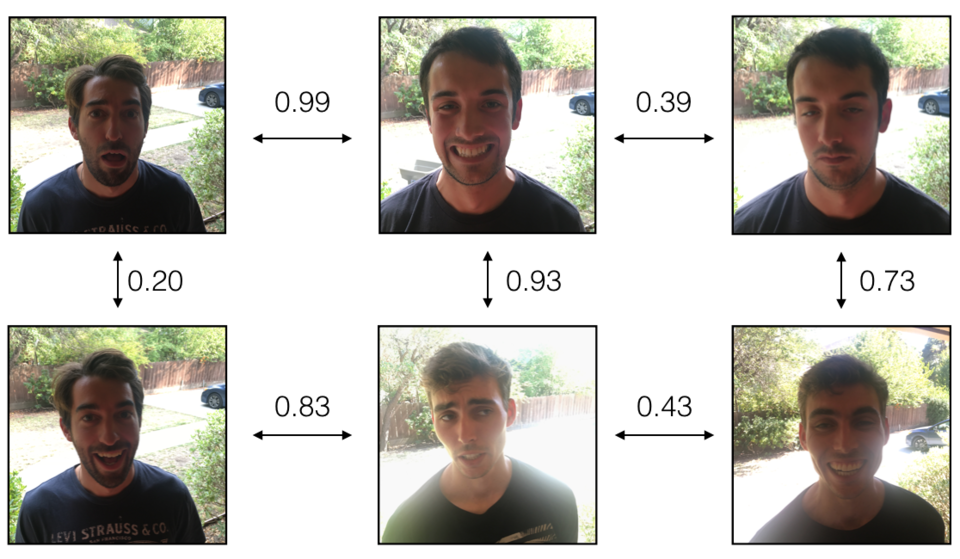

## 3.4 模型应用

① 之前我们对“欢乐家”添加了笑脸识别，现在我们要构建一个面部验证系统，以便只允许来自指定列表的人员进入。

② 为了通过门禁，每个人都必须在门口刷身份证以表明自己的身份，然后人脸识别系统将检查他们到底是谁。

### 3.4.1 人脸验证

① 让我们建立一个数据库，其中包含允许进入幸福屋的人的编码向量。

② 我们使用img_to_encoding(image_path, model)函数来生成编码，它会根据图像来进行模型的前向传播。

③ 运行以下代码以构建数据库（以python字典表示）。该数据库将每个人的姓名映射为其面部的128维编码。

In [6]:
database = {}
database["danielle"] = fr_utils.img_to_encoding("face_images/danielle.png", FRmodel)
database["younes"] = fr_utils.img_to_encoding("face_images/younes.jpg", FRmodel)
database["tian"] = fr_utils.img_to_encoding("face_images/tian.jpg", FRmodel)
database["andrew"] = fr_utils.img_to_encoding("face_images/andrew.jpg", FRmodel)
database["kian"] = fr_utils.img_to_encoding("face_images/kian.jpg", FRmodel)
database["dan"] = fr_utils.img_to_encoding("face_images/dan.jpg", FRmodel)
database["sebastiano"] = fr_utils.img_to_encoding("face_images/sebastiano.jpg", FRmodel)
database["bertrand"] = fr_utils.img_to_encoding("face_images/bertrand.jpg", FRmodel)
database["kevin"] = fr_utils.img_to_encoding("face_images/kevin.jpg", FRmodel)
database["felix"] = fr_utils.img_to_encoding("face_images/felix.jpg", FRmodel)
database["benoit"] = fr_utils.img_to_encoding("face_images/benoit.jpg", FRmodel)
database["arnaud"] = fr_utils.img_to_encoding("face_images/arnaud.jpg", FRmodel)

① 现在，当有人出现在你的门前刷他们的身份证的时候，你可以在数据库中查找他们的编码，用它来检查站在门前的人是否与身份证上的名字匹配。

② 现在我们要实现 verify() 函数来验证摄像头的照片(image_path)是否与身份证上的名称匹配，这个部分可由以下步骤构成：

 1. 从image_path计算图像的编码

 2. 计算此编码和存储在数据库中的身份图像的编码的差距

 3. 如果差距小于0.7，打开门，否则不要打开。

③ 如上所述，你应该使用L2距离（np.linalg.norm）。（注意：在此实现中，将L2距离而不是L2距离的平方与阈值0.7进行比较。）

In [7]:
def verify(image_path, identity, database, model):
    """
    对“identity”与“image_path”的编码进行验证。
    
    参数：
        image_path -- 摄像头的图片。
        identity -- 字符类型，想要验证的人的名字。
        database -- 字典类型，包含了成员的名字信息与对应的编码。
        model -- 在Keras的模型的实例。
        
    返回：
        dist -- 摄像头的图片与数据库中的图片的编码的差距。
        is_open_door -- boolean,是否该开门。
    """
    #第一步：计算图像的编码，使用fr_utils.img_to_encoding()来计算。
    encoding = fr_utils.img_to_encoding(image_path, model)
    
    #第二步：计算与数据库中保存的编码的差距
    dist = np.linalg.norm(encoding - database[identity])
    
    #第三步：判断是否打开门
    if dist < 0.7:
        print("欢迎 " + str(identity) + "回家！")
        is_door_open = True
    else:
        print("经验证，您与" + str(identity) + "不符！")
        is_door_open = False
    
    return dist, is_door_open

① 尤恩斯（Younes）试图进入快乐之家，然后相机为他拍照（"images/camera_0.jpg"）。

② 让我们在这张图片上运行你的验证算法：

In [8]:
verify("face_images/camera_0.jpg","younes",database,FRmodel)

欢迎 younes回家！


(0.66714054, True)

① 上周末破坏水族馆的Benoit已被禁止进入房屋，并已从数据库中删除。

② 他偷了Kian的身份证，试图通过门禁进入房屋。

③ 前门摄像头拍摄到Benoit的照片（"images/camera_2.jpg"）。

④ 让我们运行验证算法来检查Benoit是否可以进入。

In [9]:
verify("face_images/camera_2.jpg", "kian", database, FRmodel)

经验证，您与kian不符！


(0.85868853, False)

### 3.4.2 人脸识别

① 你的人脸验证系统在大部分情况下运行良好。但是自从肯恩（Kian）的身份证被盗以来，那天晚上他回到家中时，他进不了门了！

② 为了减少这种恶作剧，你想将人脸验证系统更改为人脸识别系统。这样，不再需要携带身份证。授权人员可以走到房屋前，前门将为他们解锁！

③ 为此，你将实现一个人脸识别系统，该系统将图像作为输入，并确定该图像是否是授权人员之一。与以前的人脸验证系统不同，我们将不再获得一个人的名字作为其他输入。

④ 现在我们要实现who_is_it()函数，实现它需要有以下步骤：

 1. 根据image_path计算图像的编码。

 2. 从数据库中找出与目标编码具有最小差距的编码。

   - 初始化min_dist变量为足够大的数字（100），它将找到与输入的编码最接近的编码。
 
   - 遍历数据库中的名字与编码，可以使用for (name, db_enc) in database.items()语句。

     - 计算目标编码与当前数据库编码之间的L2差距。

     - 如果差距小于min_dist，那么就更新名字与编码到identity与min_dist中。

In [10]:
def who_is_it(image_path, database,model):
    """
    根据指定的图片来进行人脸识别
    
    参数：
        images_path -- 图像地址
        database -- 包含了名字与编码的字典
        model -- 在Keras中的模型的实例。
        
    返回：
        min_dist -- 在数据库中与指定图像最相近的编码。
        identity -- 字符串类型，与min_dist编码相对应的名字。
    """
    #步骤1：计算指定图像的编码，使用fr_utils.img_to_encoding()来计算。
    encoding = fr_utils.img_to_encoding(image_path, model)
    
    #步骤2 ：找到最相近的编码
    ## 初始化min_dist变量为足够大的数字，这里设置为100
    min_dist = 100
    
    ## 遍历数据库找到最相近的编码
    for (name,db_enc) in database.items():
        ### 计算目标编码与当前数据库编码之间的L2差距。
        dist = np.linalg.norm(encoding - db_enc)
        
        ### 如果差距小于min_dist，那么就更新名字与编码到identity与min_dist中。
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    # 判断是否在数据库中
    if min_dist > 0.7:
        print("抱歉，您的信息不在数据库中。")
        
    else:
        print("姓名" + str(identity) + "  差距：" + str(min_dist))
    
    return min_dist, identity

① Younes站在前门，相机给他拍了张照片(“images/camera_0.jpg”)。

② 让我们看看who_it_is()算法是否识别Younes。

In [11]:
who_is_it("face_images/camera_0.jpg", database, FRmodel)

姓名younes  差距：0.66714054


(0.66714054, 'younes')